In [1]:
import pandas as pd
import os
import random
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt 

from transformers import BertModel, BertTokenizer 
import torch

/Users/sachichitre/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#import data
mammals = pd.read_excel('./data/promptListMammal.xlsx')
reptiles = pd.read_excel('./data/promptListReptile.xlsx')
birds = pd.read_excel('./data/promptListBird.xlsx')
bugs = pd.read_excel('./data/promptListBugs.xlsx')
fish = pd.read_excel('./data/promptListFish.xlsx')
 
#print(fish)

In [3]:
# Picking 15 random prompts from each dataset
# reptiles_15 = reptiles.sample(n=15, random_state=0)
reptiles_15 = reptiles.sample(n=15, random_state=0)
list_of_strings = reptiles_15[0].astype(str).tolist()

# Print the list of strings
print(list_of_strings)
# mam = mammals_15.to_string(index=False)
# mammals_sampled = mammals.sample(n=10, random_state=0)
# mammals_list = mammals_sampled.squeeze().toList()
# fish_15 = fish.sample(n=15, random_state=0)
# bugs_15 = bugs.sample(n=15, random_state=0)
# birds_15 = birds.sample(n=15, random_state=0)
print(reptiles_15)
type(reptiles_15)
# type(mammals_list)

['Is a Zong’s Odd-scaled Snake a reptile?', 'Is a Cebu Small Worm Skink a reptile?', 'Is a Black-eyed Bent-toed Gecko a reptile?', 'Is a Pig-nosed Turtle a reptile?', 'Is a Acanthodactylus harranensis a reptile?', 'Is a Gharial a reptile?', 'Is a Central American River Turtle a reptile?', 'Is a Chinese Alligator a reptile?', 'Is a Reyes’ Caribbean Gecko a reptile?', 'Is a Hispaniolan Tailspot Sphaero a reptile?', 'Is a Big-headed Amazon River Turtle a reptile?', 'Is a West African Slender-snouted Crocodile a reptile?', 'Is a Chinese Giant Salamander a reptile?', 'Is a Mount Inago Pygmy Chameleon a reptile?', 'Is a Dwarf Crocodile a reptile?']
                                                     0
48             Is a Zong’s Odd-scaled Snake a reptile?
94               Is a Cebu Small Worm Skink a reptile?
95          Is a Black-eyed Bent-toed Gecko a reptile?
8                     Is a Pig-nosed Turtle a reptile?
97         Is a Acanthodactylus harranensis a reptile?
22                 

pandas.core.frame.DataFrame

In [4]:
# Load pre-trained BertModel and BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
model = BertModel.from_pretrained('bert-base-uncased' ) 

In [5]:
# Function to find the animal name between "a" or "an" and "mammal" using vector embeddings
def find_animal_name_embeddings(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get the embeddings for the prompt
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # Shape: (num_tokens, embedding_size)
#         sentence_embedding = torch.mean(last_hidden_states, dim=1) 
#         embedding_array = sentence_embedding.detach().numpy()
    
    # Define the target words
    target_start_words = ["a", "an"]
    target_end_word = "a"

    # Initialize variables to hold the indices of the target words
    start_index = None
    end_index = None

    # Iterate through the tokens and embeddings to find the indices of the target words
    for i, token in enumerate(tokens):
        
        if token in target_start_words:
            # Check if the next token is a potential animal name
            
            for j in range(i + 1, len(tokens)):
                if tokens[j] == target_end_word:
                    start_index = i + 1
                    end_index = j
                    
                    break
#             if start_index is not None and end_index is not None:
#                 break
#     print(start_index, end_index)
     # If indices are found, calculate average embedding for the animal name
    if start_index is not None and end_index is not None:
        # Extract embeddings for the animal name
        animal_name_state = last_hidden_states[0, start_index:end_index, :]
        # Calculate mean embedding across tokens
        animal_name_embedding = animal_name_state.mean(dim=0)
        # Convert to numpy array
        animal_name_embedding_np = animal_name_embedding.detach().numpy()
        
        # Convert tokens to string
        animal_name_tokens = tokens[start_index:end_index]
        animal_name = tokenizer.convert_tokens_to_string(animal_name_tokens)
        
        return animal_name, animal_name_embedding_np
    
    # Return None if the animal name is not found
    return None, None

# Testing the function
# prompt1 = "is a brown hyena a mammal?"
# animal_name1, embeddings1 = find_animal_name_embeddings(prompt1)
# print(f"Animal name in prompt: '{animal_name1}', Embeddings shape: {embeddings1.shape}")
# print(len(embeddings1))

# prompt2 = "do you know if a platypus is a mammal?"
# animal_name2, embeddings2 = find_animal_name_embeddings(prompt2)
# print(f"Animal name in prompt: '{animal_name2}', Embeddings shape: {embeddings2.shape}")

# prompt3 = "an ostrich is a bird, but is it a mammal?"
# animal_name3, embeddings3 = find_animal_name_embeddings(prompt3)
# print(f"Animal name in prompt: '{animal_name3}', Embeddings shape: {embeddings3.shape}")


Animal name in prompt: 'brown hyena', Embeddings shape: (768,)
768


In [6]:
def getEmbedding(text):
    tokens = tokenizer(text, return_tensors='pt') 
    outputs = model(**tokens) # Transformer layers
    last_hidden_states = outputs.last_hidden_state 
    sentence_embedding = torch.mean(last_hidden_states, dim=1) 
    embedding_array = sentence_embedding.detach().numpy() 
    return embedding_array 

In [7]:
# finds the animal name token vector embeddings within prompt for mammal
vecEmbedsReptiles = []
vecName = []
for vecM in list_of_strings:
    animal_name, embeddings = find_animal_name_embeddings(vecM)
    vecEmbedsReptiles.append(embeddings)
    vecName.append(animal_name)

vecEmbedsReptiles2 = []
for vecM2 in list_of_strings:
    prompt_embedding = getEmbedding(vecM2)
    vecEmbedsReptiles2.append(prompt_embedding)
type(vecEmbedsReptiles)

# Print the list of vector embeddings of animal names
#print(vecEmbedsReptiles)
# print(vecEmbedsReptiles2)
# print(len(vecEmbedsReptiles2))

15


In [8]:
### Creating Cosine Distance Matrix ###
# print(vecEmbedsReptiles2)
vecEmbedsReptiles2_reshaped = [np.array(embedding).reshape(-1) for embedding in vecEmbedsReptiles2]
cosineMatrix = np.zeros((len(vecEmbedsReptiles), len(vecEmbedsReptiles2_reshaped)))
# Calculate cosine distances and angles between each pair of embeddings
for i in range(len(vecEmbedsReptiles)):
    for j in range(len(vecEmbedsReptiles2_reshaped)):
        cosineMatrix[i][j] = 1 - distance.cosine(vecEmbedsReptiles[i], vecEmbedsReptiles2_reshaped[j])
angleMatrix = np.arccos(cosineMatrix) * 180 / np.pi

In [9]:
angleMatrix

array([[22.81188743, 43.78082401, 43.68906463, 45.15041707, 49.39949449,
        47.3555072 , 48.64859651, 47.43286354, 44.0130029 , 45.30222382,
        45.248101  , 48.52311718, 44.1744439 , 44.78308042, 49.96366836],
       [42.80109785, 26.8453731 , 43.9738307 , 44.99079488, 45.3621901 ,
        46.9282141 , 44.59082025, 46.22857939, 40.06733739, 41.88310454,
        42.6828699 , 46.05101663, 41.34549654, 41.56311642, 47.90771457],
       [43.38262169, 44.94788925, 18.73517674, 40.88410402, 42.17975994,
        49.4543238 , 44.9519594 , 49.70426203, 43.61902648, 45.01759278,
        39.25769991, 36.72406912, 40.68290589, 38.79531466, 47.87795473],
       [39.36654403, 41.76790483, 34.5378289 , 27.66028722, 45.01164414,
        45.86588471, 39.9949104 , 42.70144982, 42.67806394, 42.57869829,
        36.73005977, 40.72340691, 39.40293799, 39.8756122 , 43.04235665],
       [49.2933003 , 47.62532318, 42.80447034, 48.41971434, 21.92862457,
        48.06605637, 46.40276835, 53.1387062 , 

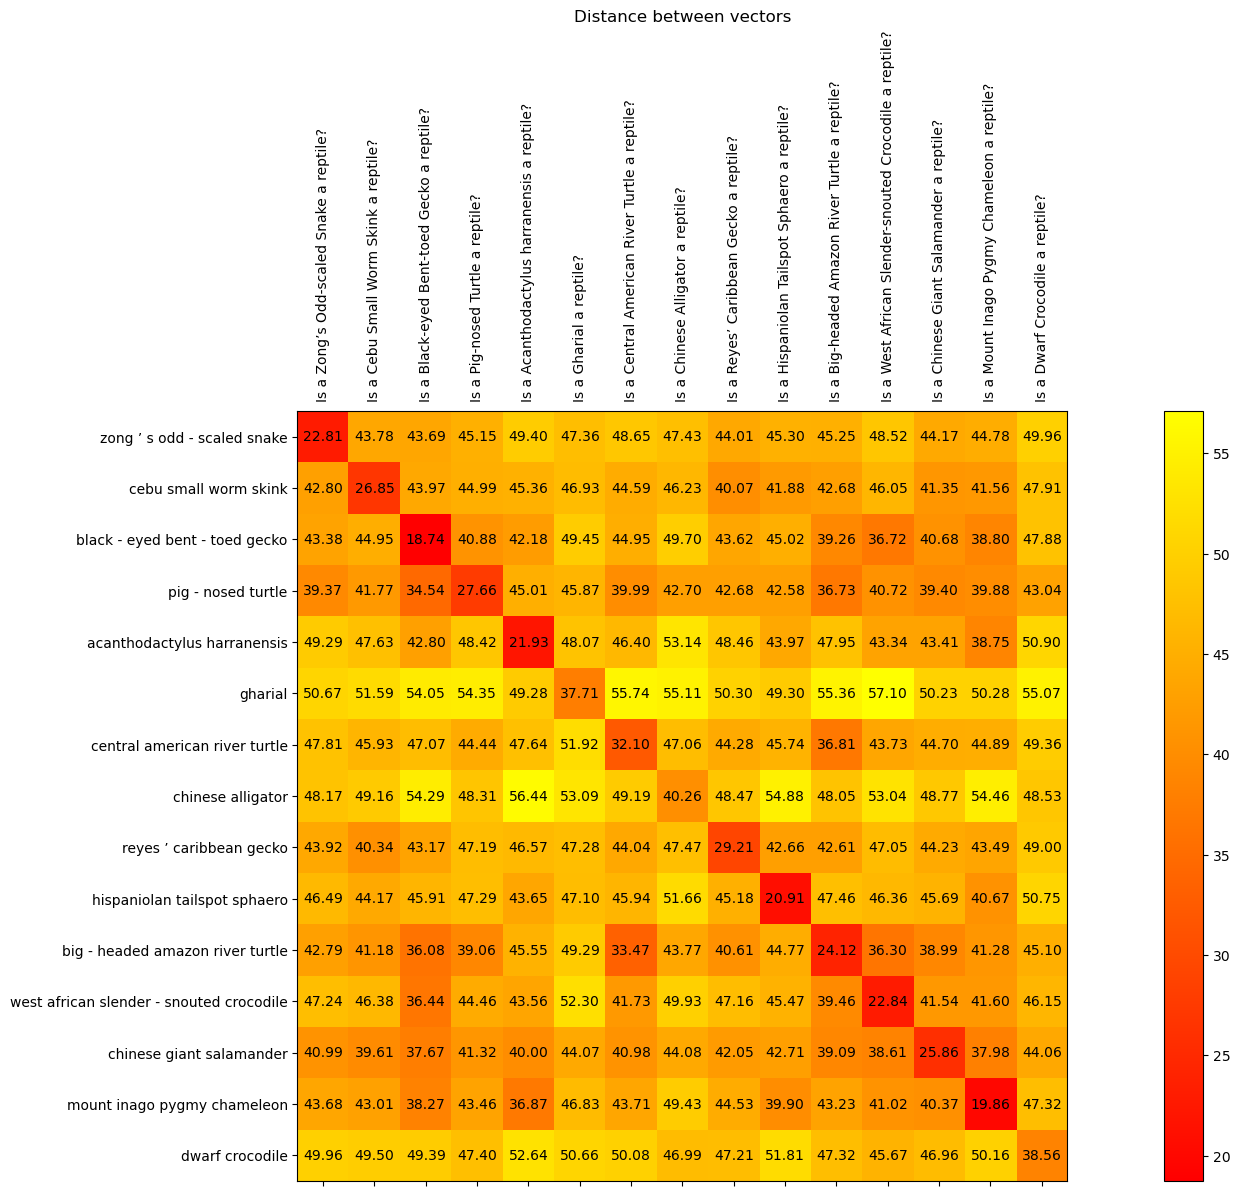

In [10]:
# Plotting Results in Heatmap
plt.figure(figsize=(25, 10)) 
plt.imshow(angleMatrix, cmap='autumn')

# Add cell values as text annotations
for i in range(len(vecEmbedsReptiles)):
    for j in range(len(vecEmbedsReptiles2_reshaped)):
        plt.annotate(f'{angleMatrix[i][j]:.2f}', xy=(j, i), ha='center', va='center')

plt.title("Distance between vectors") 
plt.xticks(np.arange(len(list_of_strings)), list_of_strings, rotation=90) #prompts
plt.yticks(np.arange(len(vecName)), vecName) # animal words
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.colorbar()